In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas import json_normalize
from mplsoccer.pitch import Pitch
plt.style.use('ggplot')


from adjustText import adjust_text
from matplotlib import cm
import matplotlib.patheffects as path_effects
%matplotlib inline

In [42]:
with open(r"Man City_Arsenal.json") as f:
    md = json.load(f)

In [43]:
side = "home" if md["home"]["name"] == "Arsenal" else "away"  
team_id = md[side]["teamId"]  
st_players = {} ##get the starting 11 players
for player in md[side]["players"]:
        if "isFirstEleven" in player:
            st_players.update({player["playerId"]: player["name"]})

In [44]:
df = json_normalize(md["events"], sep="_")

In [45]:
def get_receiver(df):
    """ Get the receiver for successful open-play passes"""

    df[["receiver_id", "receiver_team_id"]] = df[["playerId", "teamId"]].shift(-1)
    df = df.query("(outcomeType_value == 1) & (type_displayName == 'Pass') & (receiver_team_id == teamId)").reset_index(drop=True)
    df.dropna(subset=["playerId", "receiver_id", "teamId", "receiver_team_id"], inplace=True)
    df[["playerId", "receiver_id", "teamId", "receiver_team_id"]] = df[["playerId", "receiver_id", "teamId", "receiver_team_id"]].astype(int)
    return df

In [46]:
pdf = get_receiver(df)

In [47]:
pdf = pdf[pdf["qualifiers"].apply(lambda x:x not in ["Freekick", "GoalKick", "Corner"])] ##remove set-pieces

In [48]:
pdf = pdf.dropna(axis=1, how="all")

In [49]:
group1 = pdf.groupby(["playerId", "receiver_id"]).agg(count=("teamId", "size")).reset_index()

In [50]:
group1 = group1.loc[group1["count"]>1]

In [51]:
group1["count"] = group1["count"]/group1["count"].max()

In [52]:
group2 = pdf.groupby(["playerId"]).agg(x=("x", "mean"), y=("y", "mean"), total=("teamId", "size")).reset_index()

In [53]:
group2['x_loc_m'] = group2['x'] / 100 * 100
group2['y_loc_m'] = group2['y'] / 100 * 100

In [54]:
# group2['y1'] = [100 - i for i in group2['y_loc_m']] # Note y axis is flipped for vertical pitch view

In [55]:
stplist = list(st_players.keys()) ##list of starting players ids

In [56]:
group1 = group1.query("(playerId in @stplist) & (receiver_id in @stplist)").reset_index(drop=True)

In [57]:
group2 = group2.query("playerId in @stplist").reset_index(drop=True)

In [58]:
group2["player_name"] = group2["playerId"].map(st_players)

In [59]:
class Player:

    def __init__(self, name, pid, x, y, total):
        self.name = name
        self.pid = pid
        self.x = x
        self.y = y
        self.total = total

In [60]:
plr_objs = {}
for i in group2.index:
    plr_objs[group2.loc[i, "playerId"]] = Player(group2.loc[i, "player_name"], group2.loc[i, "playerId"], group2.loc[i, "y"], group2.loc[i, "x_loc_m"], group2.loc[i, "total"])

In [61]:
import matplotlib.colors

In [62]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [142]:
cmap = ListedColormap(["white","gainsboro","lightgrey","silver","darkgray","gray","dimgray"])

In [143]:
cmap2 = ListedColormap(["white","gainsboro","lightgrey","silver","darkgray"])

In [145]:
group2L

,playerId,x,y,total,x_loc_m,y_loc_m,player_name
0,11895,28.025000,57.162500,16,28.025000,57.162500,Adama Soumaoro
1,19859,33.077778,22.988889,27,33.077778,22.988889,José Fonte
2,117776,47.590476,32.250000,42,47.590476,32.250000,Thiago Mendes
3,136481,47.057576,9.851515,33,47.057576,9.851515,Mehmet Zeki Çelik
4,141646,10.175000,49.141667,12,10.175000,49.141667,Mike Maignan
5,239872,60.194444,19.033333,18,60.194444,19.033333,Nicolas Pépé
6,241019,47.892000,81.896000,25,47.892000,81.896000,Jonathan Bamba
7,322094,49.100000,66.900000,8,49.100000,66.900000,Jonathan Ikoné
8,328968,33.508696,85.804348,23,33.508696,85.804348,Fode Ballo-Toure
9,329409,46.900000,52.330000,20,46.900000,52.330000,Xeka


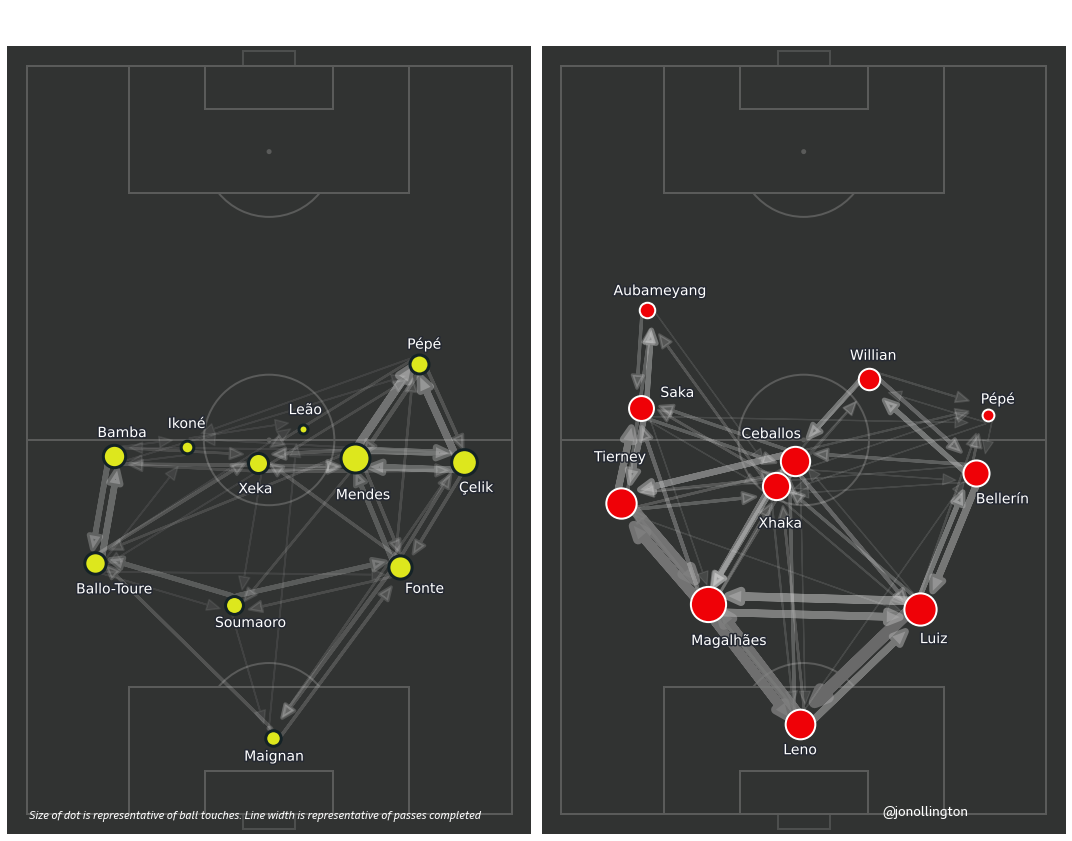

In [227]:
background = "#313332"
line = '#5a5b5a'
text_color ='white'
touches = '#f62681'
assisted = "#45c7e8"
goal = '#59c08a'
title_font = "BBC Reith Sans"
body_font = "BBC Reith Sans"

pitch = Pitch(figsize=(15,15),layout=(1,2),orientation='vertical',view='full',goal_type='box',
              pitch_type='opta', pitch_color=background, line_color=line,constrained_layout=False)

fig, ax = pitch.draw()

# draw_pitch(pitch ='#252932', line ='#383838',orientation='vertical', view='full')

csfont = {'fontname':'BBC Reith Sans'}
hfont = {'fontname':'BBC Reith Sans'}

offset = 1.1 ##change the x and y coordinates of passes between two same players so that there's no overlap

# cmap = cm.get_cmap("Greys")
cmap = ListedColormap(["white","gainsboro","lightgrey","silver","darkgray","gray","dimgray"])

shrink_val = 5 ##Units by which the arrow is shortened from the end_points

style="Simple,tail_width=0.001,head_width=1.1,head_length=1.3"

plr_objs = {}
for i in group2.index:
    plr_objs[group2.loc[i, "playerId"]] = Player(group2.loc[i, "player_name"], group2.loc[i, "playerId"], group2.loc[i, "y"], group2.loc[i, "x_loc_m"], group2.loc[i, "total"])

for (_, (pid, rid, count)) in group1.iterrows():
    if abs(plr_objs[rid].x - plr_objs[pid].x) > abs(plr_objs[rid].y - plr_objs[pid].y):
        if rid > pid:
            ax[1].annotate("", xy=(plr_objs[rid].x, plr_objs[rid].y + offset), xytext=(plr_objs[pid].x, plr_objs[pid].y + offset),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*12,"color":cmap(count), "alpha":count, "linestyle":"solid", "shrinkB":20},zorder=9)
        elif pid > rid:
            ax[1].annotate("", xy=(plr_objs[rid].x, plr_objs[rid].y - offset), xytext=(plr_objs[pid].x, plr_objs[pid].y - offset),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*12,"color":cmap(count), "alpha":count, "linestyle":"solid", "shrinkB":20},zorder=9)
    
    elif abs(plr_objs[rid].x - plr_objs[pid].x) <= abs(plr_objs[rid].y - plr_objs[pid].y):
        if rid > pid:
            ax[1].annotate("", xy=(plr_objs[rid].x + offset, plr_objs[rid].y), xytext=(plr_objs[pid].x + offset, plr_objs[pid].y),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*12, "color":cmap(count),"alpha":count, "linestyle":"solid", "shrinkB":20},zorder=9)
        elif pid > rid:
            ax[1].annotate("", xy=(plr_objs[rid].x - offset, plr_objs[rid].y), xytext=(plr_objs[pid].x - offset, plr_objs[pid].y),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*12, "color":cmap(count),"alpha":count, "linestyle":"solid", "shrinkB":20},zorder=9)

texts = []        
for player_id, player_obj in plr_objs.items():
    ax[1].scatter(player_obj.x, player_obj.y, s=player_obj.total*20, color="#EF0107", ec="white", lw="2",alpha=1, zorder=10)
    if player_obj.name == "Nicolas Pépé":
        t1 = plt.text(player_obj.x+1.5,player_obj.y+1.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t1.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Pierre-Emerick Aubameyang":
        t2 = plt.text(player_obj.x+7,player_obj.y+2,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Kieran Tierney":
        t2 = plt.text(player_obj.x+5.5,player_obj.y+5.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Willian":
        t2 = plt.text(player_obj.x+4,player_obj.y+2.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Bukayo Saka":
        t2 = plt.text(player_obj.x-4,player_obj.y+1.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Dani Ceballos":
        t2 = plt.text(player_obj.x+11,player_obj.y+3,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Bernd Leno":
        t2 = plt.text(player_obj.x+3.5,player_obj.y-4,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Héctor Bellerín":
        t2 = plt.text(player_obj.x,player_obj.y-4,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "David Luiz":
        t2 = plt.text(player_obj.x,player_obj.y-4.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    else:
        t = plt.text(player_obj.x+3.5, player_obj.y-5.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])

        

        
plr_objs1 = {}
for i in group2L.index:
    plr_objs1[group2L.loc[i, "playerId"]] = Player1(group2L.loc[i, "player_name"], group2L.loc[i, "playerId"], group2L.loc[i, "y"], group2L.loc[i, "x_loc_m"], group2L.loc[i, "total"])

for (_, (pid, rid, count)) in group1L.iterrows():
    if abs(plr_objs1[rid].x - plr_objs1[pid].x) > abs(plr_objs1[rid].y - plr_objs1[pid].y):
        if rid > pid:
            ax[0].annotate("", xy=(plr_objs1[rid].x, plr_objs1[rid].y + offset), xytext=(plr_objs1[pid].x, plr_objs1[pid].y + offset),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*20,"color":cmap2(count), "alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)
        elif pid > rid:
            ax[0].annotate("", xy=(plr_objs1[rid].x, plr_objs1[rid].y - offset), xytext=(plr_objs1[pid].x, plr_objs1[pid].y - offset),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*20,"color":cmap2(count), "alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)
    
    elif abs(plr_objs1[rid].x - plr_objs1[pid].x) <= abs(plr_objs1[rid].y - plr_objs1[pid].y):
        if rid > pid:
            ax[0].annotate("", xy=(plr_objs1[rid].x + offset, plr_objs1[rid].y), xytext=(plr_objs1[pid].x + offset, plr_objs1[pid].y),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*20, "color":cmap2(count),"alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)
        elif pid > rid:
            ax[0].annotate("", xy=(plr_objs1[rid].x - offset, plr_objs1[rid].y), xytext=(plr_objs1[pid].x - offset, plr_objs1[pid].y),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*20, "color":cmap2(count),"alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)

texts = []        
for player_id, player_obj1 in plr_objs1.items():
    ax[0].scatter(player_obj1.x, player_obj1.y, s=player_obj1.total*20, color="#dde71d", ec="#142226", lw="3",alpha=1, zorder=10)
    if player_obj1.name == "Nicolas Pépé":
        t1 = ax[0].text(player_obj1.x+2.5,player_obj1.y+2,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t1.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "Rafael Leão":
        t2 = ax[0].text(player_obj1.x+3,player_obj1.y+2,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "Jonathan Bamba":
        t2 = ax[0].text(player_obj1.x+3.5,player_obj1.y+2.5,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "Jonathan Ikoné":
        t2 = ax[0].text(player_obj1.x+4,player_obj1.y+2.5,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "José Fonte":
        t2 = ax[0].text(player_obj1.x-1,player_obj1.y-3.5,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "Mike Maignan":
        t2 = ax[0].text(player_obj1.x+6,player_obj1.y-3,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "Adama Soumaoro":
        t2 = ax[0].text(player_obj1.x+4,player_obj1.y-3,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "Mehmet Zeki Çelik":
        t2 = ax[0].text(player_obj1.x+1,player_obj1.y-4,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj1.name == "Thiago Mendes":
        t2 = ax[0].text(player_obj1.x+4,player_obj1.y-5.5,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    else:
        t = ax[0].text(player_obj1.x+4, player_obj1.y-4,color="white", s=player_obj1.name.split(" ")[-1], fontsize=14, rotation=0, zorder=12)
        t.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    
    
# #title

ax[0].text(100, 105.9, "Paris Saint-Germain vs Lille OSC",fontsize=20, fontfamily=body_font, color='white', weight='bold',zorder=2, **csfont)
ax[0].text(100, 103.5, "Ligue 1 | Season 2018/19 | Positions & Passing Network",fontsize=13, fontfamily=body_font, color=text_color,zorder=2, **csfont)

ax[1].text(100, 105.9, "Manchester City vs Arsenal",fontsize=20, fontfamily=body_font, color='white', weight='bold',zorder=2, **csfont)
ax[1].text(100, 103.5, "English Premier League | Season 2020/21 | Positions & Passing Network",fontsize=13, fontfamily=body_font, color=text_color,zorder=2, **csfont)

subtitle_string = 'Size of dot is representative of ball touches. Line width is representative of passes completed'
fig.text(.03,0.15, subtitle_string, fontsize=11,**csfont, color='white',zorder=20, fontstyle='italic')

info_string = '@jonollington'
fig.text(0.82, 0.15, info_string, color='#ffffff', ha='left', va='bottom', fontsize=13, **csfont)

plt.rcParams['axes.facecolor']=background
plt.rcParams['savefig.facecolor']=background

plt.savefig("Arsenal_City",bbox_inches="tight",dpi=500)

In [89]:
with open(r"PSG_Lille.json") as f:
    md1 = json.load(f)

In [90]:
side1 = "home" if md1["home"]["name"] == "Lille" else "away"  
team_id1 = md1[side1]["teamId"]  
st_players1 = {} ##get the starting 11 players
for player1 in md1[side1]["players"]:
        if "isFirstEleven" in player1:
            st_players1.update({player1["playerId"]: player1["name"]})

In [91]:
df1 = json_normalize(md1["events"], sep="_")

In [92]:
def get_receiver(df):
    """ Get the receiver for successful open-play passes"""

    df[["receiver_id", "receiver_team_id"]] = df[["playerId", "teamId"]].shift(-1)
    df = df.query("(outcomeType_value == 1) & (type_displayName == 'Pass') & (receiver_team_id == teamId)").reset_index(drop=True)
    df.dropna(subset=["playerId", "receiver_id", "teamId", "receiver_team_id"], inplace=True)
    df[["playerId", "receiver_id", "teamId", "receiver_team_id"]] = df[["playerId", "receiver_id", "teamId", "receiver_team_id"]].astype(int)
    return df

In [93]:
pdf1 = get_receiver(df1)

In [94]:
pdf1 = pdf1[pdf1["qualifiers"].apply(lambda x:x not in ["Freekick", "GoalKick", "Corner"])] ##remove set-pieces

In [95]:
pdf1 = pdf1.dropna(axis=1, how="all")

In [96]:
group1L = pdf1.groupby(["playerId", "receiver_id"]).agg(count=("teamId", "size")).reset_index()

In [97]:
group1L = group1L.loc[group1L["count"]>1]

In [98]:
group1L["count"] = group1L["count"]/group1L["count"].max()

In [99]:
group2L = pdf1.groupby(["playerId"]).agg(x=("x", "mean"), y=("y", "mean"), total=("teamId", "size")).reset_index()

In [100]:
group2L['x_loc_m'] = group2L['x'] / 100 * 100
group2L['y_loc_m'] = group2L['y'] / 100 * 100

In [101]:
stplist1 = list(st_players1.keys()) ##list of starting players ids

In [102]:
group1L = group1L.query("(playerId in @stplist1) & (receiver_id in @stplist1)").reset_index(drop=True)

In [103]:
group2L = group2L.query("playerId in @stplist1").reset_index(drop=True)

In [104]:
group2L["player_name"] = group2L["playerId"].map(st_players1)

In [105]:
class Player1:

    def __init__(self, name, pid, x, y, total):
        self.name = name
        self.pid = pid
        self.x = x
        self.y = y
        self.total = total

In [106]:
plr_objs1 = {}
for i in group2L.index:
    plr_objs1[group2L.loc[i, "playerId"]] = Player1(group2L.loc[i, "player_name"], group2L.loc[i, "playerId"], group2L.loc[i, "y"], group2L.loc[i, "x_loc_m"], group2L.loc[i, "total"])